# Técnicas de reducción de Dimensionalidad sobre un Dataset de Estilo de Vida y Salud

---

Este notebook implementa una comparativa exhaustiva de modelos de clasificación utilizando técnicas de reducción de dimensionalidad **PCA (Análisis de Componentes Principales)** y **MCA (Análisis de Correspondencias Múltiples)**, entre otras, en un dataset de estilo de vida y salud.

### Objetivos:
- Aplicar técnicas de selección de características y reducción de dimensionalidad
- Analizar el impacto de PCA en variables numéricas y MCA en variables categóricas

### Dataset:
**Health Lifestyle Dataset** con información de 100,000 personas incluyendo:
- **Variables numéricas**: age, bmi, blood_pressure, cholesterol, etc.
- **Variables categóricas**: gender, marital_status, diet_type, occupation, etc.
- **Target**: Clasificación binaria (healthy/diseased) - ~70% sanos, ~30% enfermos

---

## 1. Importación de libreria

In [87]:
# Bibliotecas principales
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import os
# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)

# Preprocessing y división de datos
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Reducción de dimensionalidad
from sklearn.decomposition import PCA
%pip install mca
import mca  # Para MCA

# Modelos de clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier

# Métricas de evaluación
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, confusion_matrix,
                           classification_report, roc_curve, auc)

# Utilidades adicionales
import time
from collections import defaultdict
# Kaggle
import kagglehub

In [88]:
path = kagglehub.dataset_download("mahdimashayekhi/disease-risk-from-daily-habits")
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
csv_path = os.path.join(path, csv_files[0])
df = pd.read_csv(csv_path)
# Muestreo aleatorio de 20000 registros
df = df.sample(n=20000, random_state=42).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   survey_code               20000 non-null  int64  
 1   age                       20000 non-null  int64  
 2   gender                    20000 non-null  object 
 3   height                    20000 non-null  float64
 4   weight                    20000 non-null  float64
 5   bmi                       20000 non-null  float64
 6   bmi_estimated             20000 non-null  float64
 7   bmi_scaled                20000 non-null  float64
 8   bmi_corrected             20000 non-null  float64
 9   waist_size                20000 non-null  float64
 10  blood_pressure            18454 non-null  float64
 11  heart_rate                17256 non-null  float64
 12  cholesterol               20000 non-null  float64
 13  glucose                   20000 non-null  float64
 14  insuli

In [89]:
# Eliminar surveycode y electrolyte_level
columns_to_drop = ['survey_code', 'electrolyte_level']
df.drop(columns=columns_to_drop, inplace=True)
# Separar columnas por tipo de dato
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
# Excluir la columna objetivo de ambas listas
if 'target' in numerical_cols:
    numerical_cols.remove('target')
if 'target' in categorical_cols:
    categorical_cols.remove('target')

## 2. Exploratory Data Analysis (EDA)

Realizamos un análisis exploratorio completo para entender la estructura de los datos, distribuciones, correlaciones y relaciones con la variable objetivo.

In [90]:
print(f"Dimensiones: {df.shape}")

Dimensiones: (20000, 46)


In [91]:
print(f"Valores faltantes: {df.isnull().sum().sum()}")

Valores faltantes: 33176


In [92]:
print(f"Tipos de datos:")
print(df.dtypes.value_counts())

Tipos de datos:
float64    24
object     18
int64       4
Name: count, dtype: int64


In [93]:
target_counts = df['target'].value_counts()
target_props = df['target'].value_counts(normalize=True)
for val in target_counts.index:
    print(f"{val}: {target_counts[val]:,} ({target_props[val]:.2%})")

healthy: 13,977 (69.88%)
diseased: 6,023 (30.11%)


In [94]:
print(f"Variables numéricas ({len(numerical_cols)}): {numerical_cols}")
print(f"Variables categóricas ({len(categorical_cols)}): {categorical_cols}")

Variables numéricas (28): ['age', 'height', 'weight', 'bmi', 'bmi_estimated', 'bmi_scaled', 'bmi_corrected', 'waist_size', 'blood_pressure', 'heart_rate', 'cholesterol', 'glucose', 'insulin', 'sleep_hours', 'work_hours', 'physical_activity', 'daily_steps', 'calorie_intake', 'sugar_intake', 'water_intake', 'screen_time', 'stress_level', 'mental_health_score', 'income', 'meals_per_day', 'gene_marker_flag', 'environmental_risk_score', 'daily_supplement_dosage']
Variables categóricas (17): ['gender', 'sleep_quality', 'alcohol_consumption', 'smoking_level', 'mental_health_support', 'education_level', 'job_type', 'occupation', 'diet_type', 'exercise_type', 'device_usage', 'healthcare_access', 'insurance', 'sunlight_exposure', 'caffeine_intake', 'family_history', 'pet_owner']


In [95]:
df.describe().round(2)

,age,height,weight,bmi,bmi_estimated,bmi_scaled,bmi_corrected,waist_size,blood_pressure,heart_rate,...,sugar_intake,water_intake,screen_time,stress_level,mental_health_score,income,meals_per_day,gene_marker_flag,environmental_risk_score,daily_supplement_dosage
count,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,18454.00,17256.00,...,20000.00,20000.00,20000.00,20000.00,20000.00,18286.00,20000.00,17956.0,20000.0,20000.00
mean,48.54,169.91,70.07,24.53,24.53,73.60,24.53,84.85,120.06,75.02,...,59.94,2.01,6.02,4.97,4.99,4035.88,3.00,1.0,5.5,-0.03
std,17.91,10.02,14.72,5.98,5.98,17.95,5.99,12.08,14.99,9.92,...,19.90,0.69,2.93,3.15,3.15,1939.26,1.41,0.0,0.0,5.78
min,18.00,140.00,40.00,10.33,10.33,30.98,10.31,34.09,64.35,37.46,...,-18.03,0.50,0.00,0.00,0.00,500.00,1.00,1.0,5.5,-10.00
25%,33.00,163.27,59.82,20.31,20.31,60.92,20.30,76.71,109.96,68.37,...,46.59,1.53,3.97,2.00,2.00,2646.61,2.00,1.0,5.5,-5.03
50%,49.00,169.90,69.85,24.19,24.19,72.58,24.18,84.89,119.99,75.17,...,59.91,2.00,5.99,5.00,5.00,3999.25,3.00,1.0,5.5,-0.07
75%,64.00,176.64,80.01,28.29,28.29,84.88,28.28,92.93,130.10,81.76,...,73.31,2.48,8.05,8.00,8.00,5366.96,4.00,1.0,5.5,5.01
max,79.00,210.00,133.80,56.71,56.71,170.12,56.63,130.70,182.80,111.09,...,141.51,5.00,16.00,10.00,10.00,11369.22,5.00,1.0,5.5,10.00


### ¿Cuál es la distribución de la variable objetivo ('target')?

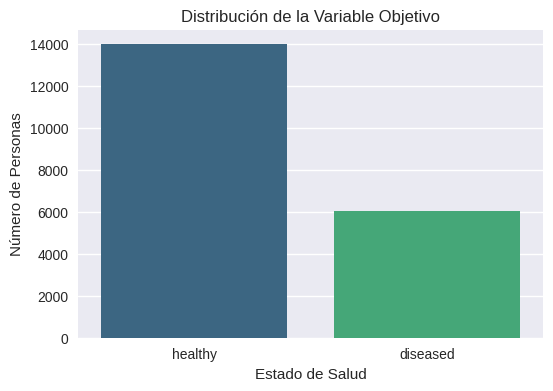

Distribución absoluta:
target
healthy     13977
diseased     6023
Name: count, dtype: int64

Distribución porcentual:
target
healthy     0.69885
diseased    0.30115
Name: proportion, dtype: float64


In [96]:
# Distribución de la variable objetivo
target_counts = df['target'].value_counts()
target_props = df['target'].value_counts(normalize=True)

plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df, palette='viridis')
plt.title('Distribución de la Variable Objetivo')
plt.xlabel('Estado de Salud')
plt.ylabel('Número de Personas')
plt.show()

print("Distribución absoluta:")
print(target_counts)
print("\nDistribución porcentual:")
print(target_props)

**Respuesta:** La variable objetivo ('target') muestra un desbalance de clases significativo, con aproximadamente un 70% de registros 'healthy' (sanos) y un 30% 'diseased' (enfermos). Esto es importante considerarlo durante la evaluación del modelo, posiblemente usando métricas más allá de la precisión simple (como F1-score, Recall, Precision o AUC).

### ¿Cómo se distribuyen algunas variables numéricas clave?

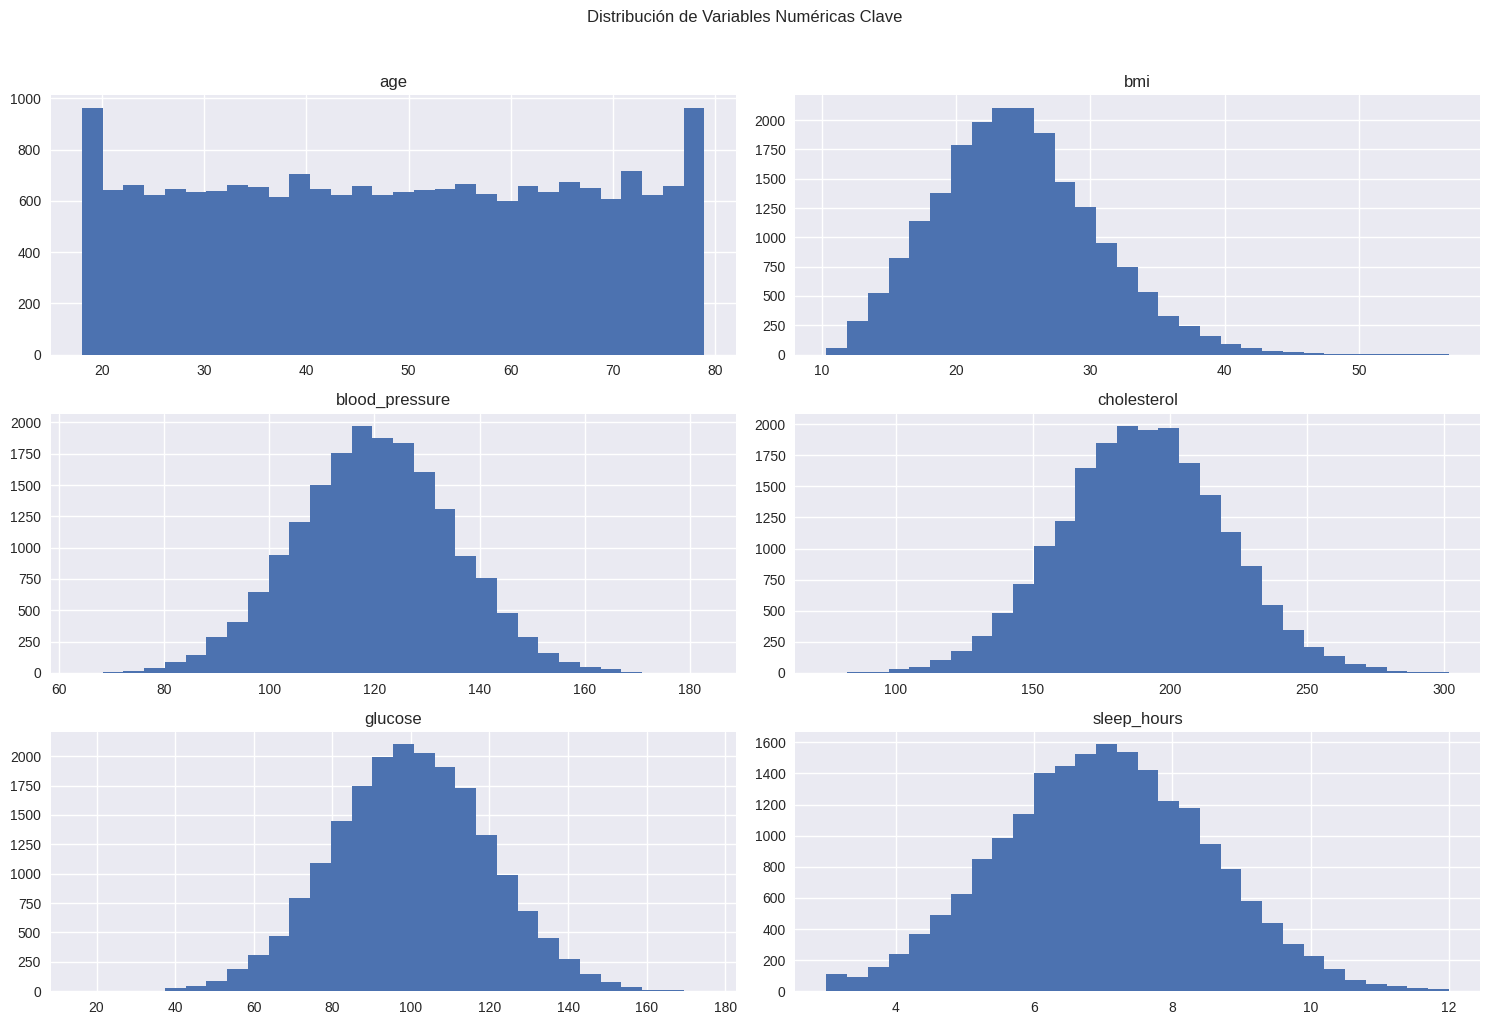

In [97]:
# Distribución de algunas variables numéricas clave
numerical_vars_to_plot = ['age', 'bmi', 'blood_pressure', 'cholesterol', 'glucose', 'sleep_hours']

df[numerical_vars_to_plot].hist(bins=30, figsize=(15, 10))
plt.suptitle('Distribución de Variables Numéricas Clave', y=1.02)
plt.tight_layout()
plt.show()

**Respuesta:** Observamos las distribuciones de algunas variables numéricas. Por ejemplo, la 'age' parece tener una distribución relativamente uniforme, mientras que 'bmi' y 'sleep_hours' muestran picos. 'blood_pressure', 'cholesterol' y 'glucose' tienen distribuciones que parecen un poco sesgadas. Estas distribuciones informan las decisiones sobre el preprocesamiento (como el escalado).

### ¿Existen correlaciones entre las variables numéricas?

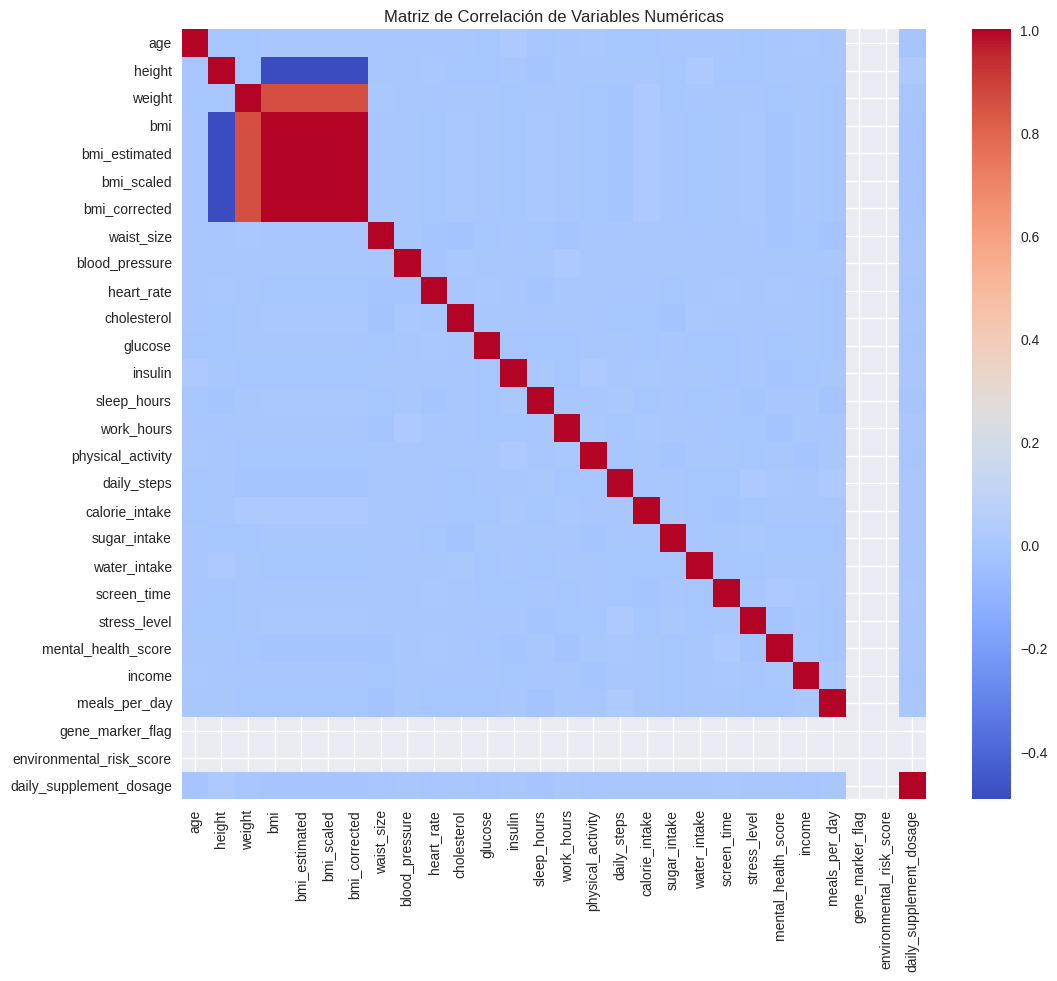

In [98]:
# Matriz de correlación de variables numéricas
plt.figure(figsize=(12, 10))
sns.heatmap(df[numerical_cols].corr(), annot=False, cmap='coolwarm')
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

**Respuesta:** El mapa de calor de correlación nos ayuda a identificar relaciones lineales entre las variables numéricas. Algunas variables como 'bmi', 'bmi_estimated', 'bmi_scaled' y 'bmi_corrected' están altamente correlacionadas entre sí (como era de esperar). 'weight' y 'height' también muestran correlación con las variables BMI. Estas correlaciones pueden ser relevantes para la selección de características o la interpretación del modelo.

### ¿Cómo se relacionan algunas variables categóricas con la variable objetivo?

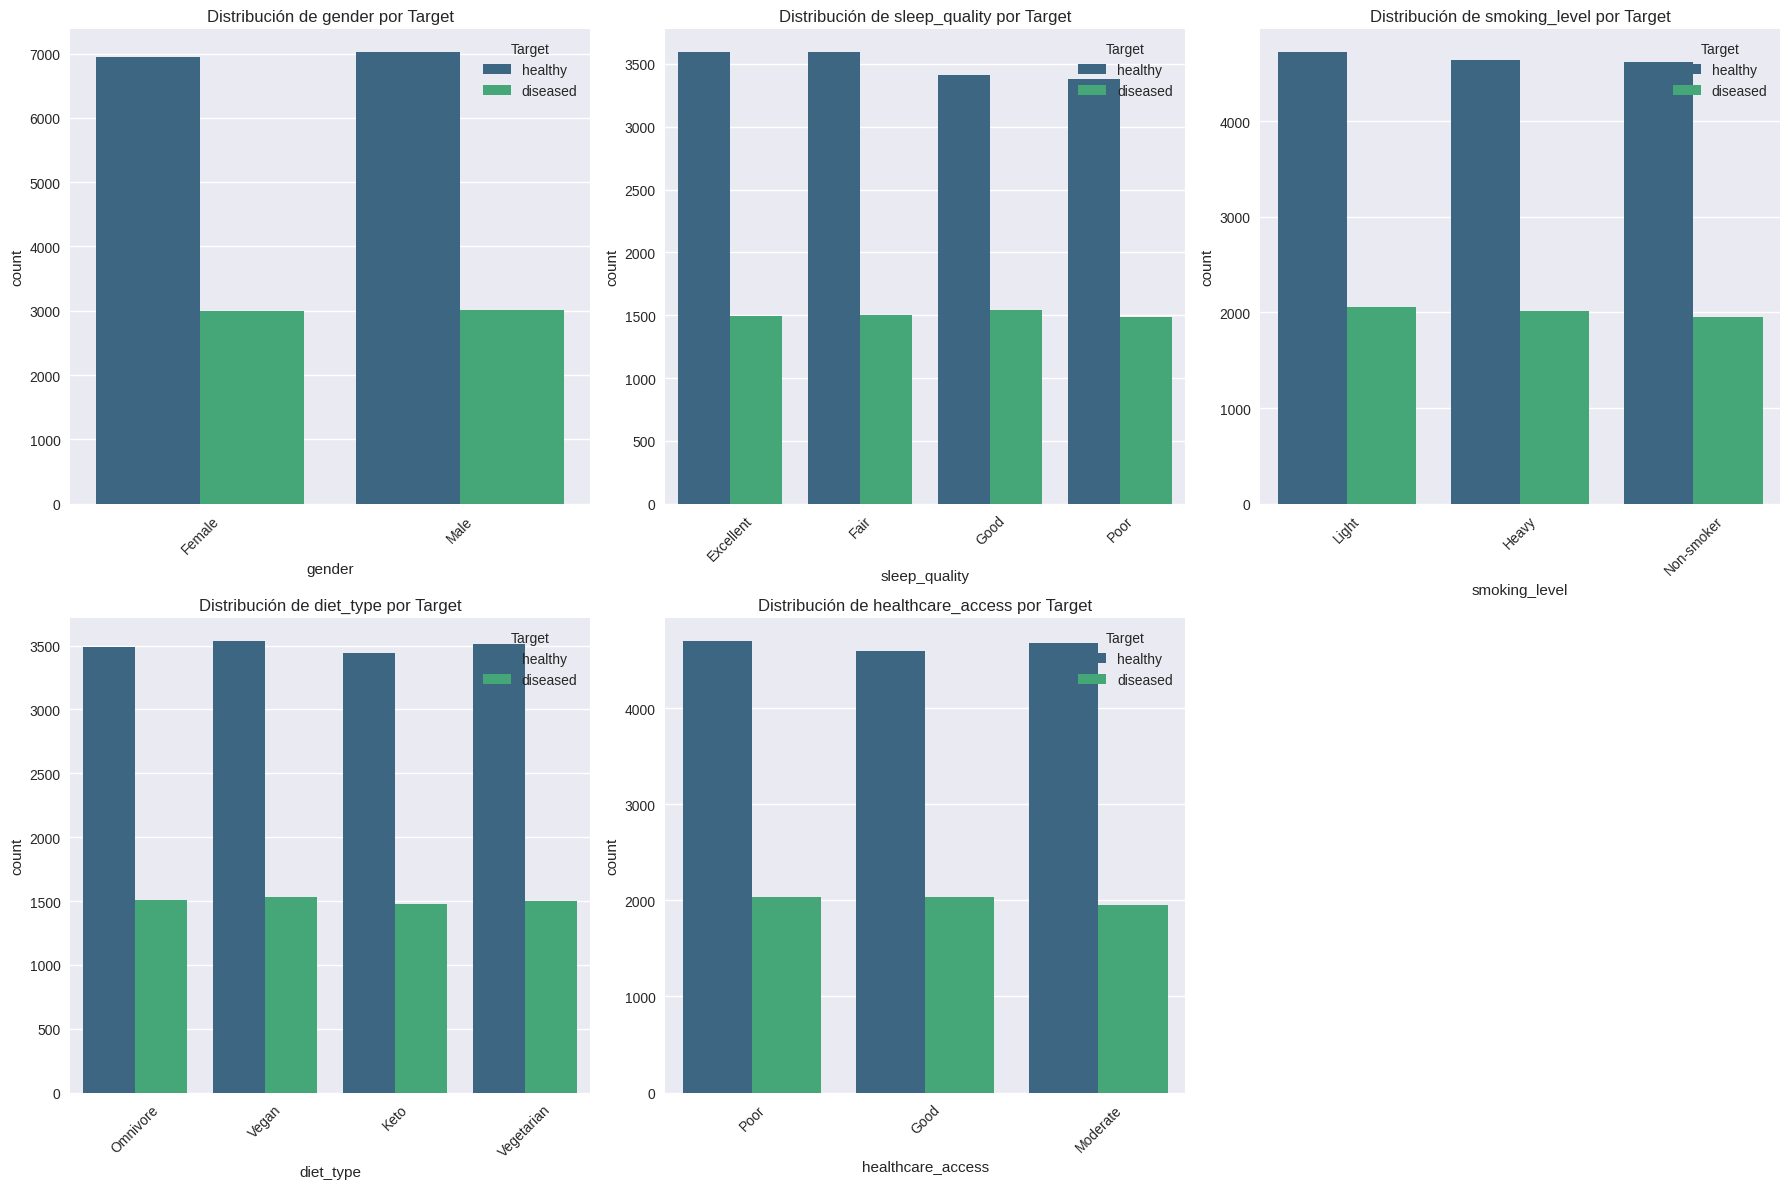

In [99]:
# Relación de algunas variables categóricas con la variable objetivo
categorical_vars_to_plot = ['gender', 'sleep_quality', 'smoking_level', 'diet_type', 'healthcare_access']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_vars_to_plot):
    # Verificar si la columna existe en el DataFrame y si es categórica (object)
    if col in df.columns and df[col].dtype == 'object':
        # Verificar si la columna tiene un número razonable de valores únicos para un countplot
        if df[col].nunique() < 50: # Umbral arbitrario, se puede ajustar
            sns.countplot(x=col, hue='target', data=df, palette='viridis', ax=axes[i])
            axes[i].set_title(f'Distribución de {col} por Target')
            # Se corrigió la rotación: 'ha' no es un argumento válido para tick_params.
            # La alineación horizontal se maneja con la rotación y el layout.
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].legend(title='Target')


# Ocultar subgráficos vacíos si hay menos de 6 variables para plotear o si se saltaron variables
# Recalcular el número de subgráficos usados
used_axes_count = len([ax for ax in axes if ax.has_data()]) # Verificar si el subgráfico contiene datos

for j in range(used_axes_count, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

**Respuesta:** Los gráficos de barras agrupadas muestran cómo la distribución de la variable objetivo varía dentro de cada categoría. Por ejemplo, podríamos observar si ciertas calidades de sueño, niveles de tabaquismo o tipos de dieta tienen una mayor proporción de individuos 'diseased'. Esto proporciona información visual sobre la posible relevancia predictiva de estas variables categóricas. No obstante, todas parecen tener la misma proporción con la variable objetivo

## 3. Preprocesamiento de datos

Preparamos los datos para el modelado, incluyendo la codificación de variables categóricas, estandarización de variables numéricas y división en conjuntos de entrenamiento y prueba.

In [100]:
# Separar X e y
X = df.drop('target', axis=1)
y = df['target']

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # Added stratify

# Imputación y escalado para variables numéricas, estrategia de media
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Imputación y codificación para variables categóricas
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer para aplicar los pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

# Aplicar preprocesamiento por separado en train y test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test) # Usar transform() en test para evitar data leakage


print(f"Shape de X_train_processed: {X_train_processed.shape}")
print(f"Shape de X_test_processed: {X_test_processed.shape}")

Shape de X_train_processed: (14000, 81)
Shape de X_test_processed: (6000, 81)


## 4. Técnicas de Selección

### SelectKBest

#### Chi-Cuadrado

NaNs remaining after processing for chi2: 0
Número de características para alcanzar el 90% del puntaje total: 34
Características seleccionadas (34): ['mental_health_score', 'age', 'occupation_Engineer', 'insulin', 'device_usage_High', 'height', 'meals_per_day', 'alcohol_consumption_Occasionally', 'sleep_quality_Good', 'job_type_Tech', 'job_type_Office', 'education_level_PhD', 'heart_rate', 'sleep_quality_Excellent', 'job_type_Service', 'device_usage_Moderate', 'healthcare_access_Moderate', 'sugar_intake', 'sleep_quality_Fair', 'healthcare_access_Good', 'alcohol_consumption_Regularly', 'occupation_Farmer', 'pet_owner_Yes', 'pet_owner_No', 'weight', 'physical_activity', 'bmi_estimated', 'bmi', 'bmi_scaled', 'caffeine_intake_High', 'screen_time', 'sleep_quality_Poor', 'occupation_Doctor', 'bmi_corrected']


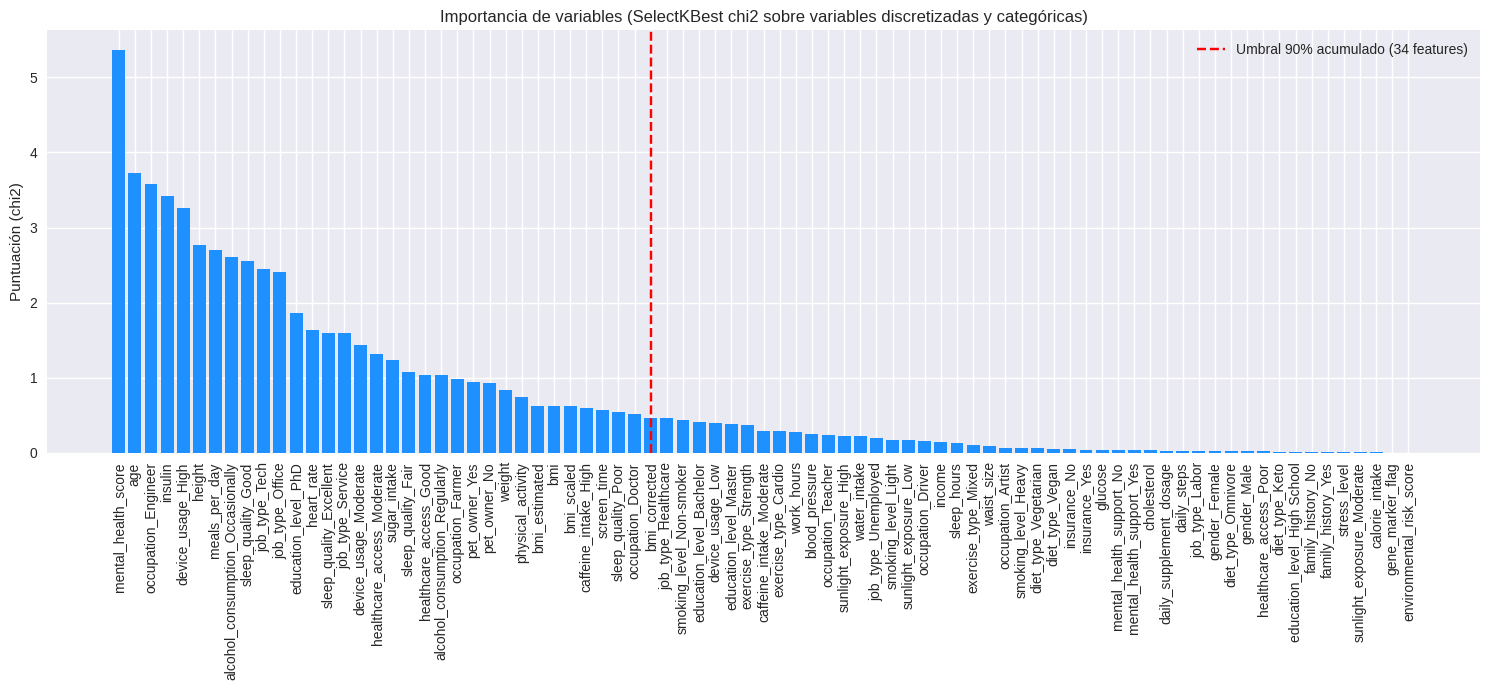

In [101]:
# Para aplicar chi2 correctamente, discretizamos las variables numéricas.
# Usaremos el DataFrame original X antes del preprocesamiento completo.

# Separar variables numéricas y categóricas del DataFrame original X
X_num_original = X[numerical_cols]
X_cat_original = X[categorical_cols]

# Imputar valores faltantes en variables numéricas antes de discretizar
imputer_num = SimpleImputer(strategy='mean')
X_num_imputed = imputer_num.fit_transform(X_num_original)
X_num_imputed_df = pd.DataFrame(X_num_imputed, columns=numerical_cols)

# Discretizar variables numéricas en 3 categorías (tercios)
# Usamos pd.qcut para discretizar en base a cuantiles.
# duplicates='drop' maneja casos donde hay valores duplicados en los cuantiles.
# Agregamos manejo de errores en apply para identificar columnas problemáticas si persisten NaNs
X_num_discretized = X_num_imputed_df.apply(lambda col: pd.qcut(col, q=3, labels=False, duplicates='drop', retbins=False) if col.nunique() > 3 else col)


# Imputar valores faltantes en variables categóricas antes de codificar
imputer_cat = SimpleImputer(strategy='most_frequent')
X_cat_imputed = imputer_cat.fit_transform(X_cat_original)
X_cat_imputed_df = pd.DataFrame(X_cat_imputed, columns=categorical_cols)

# Codificar variables categóricas
encoder_cat = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat_encoded = encoder_cat.fit_transform(X_cat_imputed_df)
cat_feature_names = encoder_cat.get_feature_names_out(categorical_cols)
X_cat_encoded_df = pd.DataFrame(X_cat_encoded, columns=cat_feature_names)


# Combinar variables numéricas discretizadas y categóricas codificadas
# Asegurarse de que los índices coincidan
X_processed_for_chi2 = pd.concat([X_num_discretized, X_cat_encoded_df], axis=1)

# Verificar si aún hay NaNs después de la combinación
print("NaNs remaining after processing for chi2:", X_processed_for_chi2.isnull().sum().sum())

# Si todavía hay NaNs, aplicar una imputación final (por ejemplo, con la moda)
# Esto podría ocurrir si pd.qcut no pudo discretizar una columna correctamente.
if X_processed_for_chi2.isnull().sum().sum() > 0:
    final_imputer = SimpleImputer(strategy='most_frequent')
    X_processed_for_chi2_imputed = final_imputer.fit_transform(X_processed_for_chi2)
    X_processed_for_chi2 = pd.DataFrame(X_processed_for_chi2_imputed, columns=X_processed_for_chi2.columns)
    print("NaNs remaining after final imputation:", X_processed_for_chi2.isnull().sum().sum())


# Aplicar SelectKBest con chi2 sobre los datos preparados
selector = SelectKBest(score_func=chi2, k='all')
# chi2 requiere datos no negativos, lo cual se cumple con la discretización (labels=False -> 0, 1, 2)
# y con OneHotEncoder (0, 1).
selector.fit(X_processed_for_chi2, y)

scores_filter = selector.scores_
features = X_processed_for_chi2.columns

# Ordenar variables por puntuación descendente
indices_filter = np.argsort(scores_filter)[::-1]
sorted_scores_filter = scores_filter[indices_filter]
sorted_features_filter = features[indices_filter]

# Cálculo del porcentaje acumulado de la puntuación
cumulative_filter = np.cumsum(sorted_scores_filter) / np.sum(sorted_scores_filter)

# Seleccionar variables que acumulan hasta 90% del total de puntuación
cutoff_index_filter = np.searchsorted(cumulative_filter, 0.90) + 1
selected_filter_count = cutoff_index_filter
selected_features_by_filter = sorted_features_filter[:selected_filter_count]

print(f"Número de características para alcanzar el 90% del puntaje total: {selected_filter_count}")
print(f"Características seleccionadas ({selected_filter_count}): {list(selected_features_by_filter)}")


# Graficar puntuaciones y el umbral 90%
plt.figure(figsize=(15,7)) # Aumentar tamaño para mejor visualización con muchas features
plt.bar(range(len(sorted_scores_filter)), sorted_scores_filter, color='dodgerblue')
plt.xticks(range(len(sorted_features_filter)), sorted_features_filter, rotation=90)
plt.ylabel("Puntuación (chi2)")
plt.title("Importancia de variables (SelectKBest chi2 sobre variables discretizadas y categóricas)")
# El umbral es cutoff_index_filter - 1 porque los índices son base 0
plt.axvline(cutoff_index_filter - 1, color='red', linestyle='--', label=f'Umbral 90% acumulado ({cutoff_index_filter} features)')
plt.legend()
plt.tight_layout() # Ajusta el diseño para evitar solapamiento
plt.show()

#### Mutual Information

Número de características para alcanzar al menos el 90% del puntaje total (Mutual Information): 33
Características seleccionadas (33): ['age', 'insurance_Yes', 'education_level_Bachelor', 'gene_marker_flag', 'alcohol_consumption_Occasionally', 'daily_supplement_dosage', 'waist_size', 'blood_pressure', 'environmental_risk_score', 'device_usage_High', 'gender_Female', 'job_type_Unemployed', 'cholesterol', 'caffeine_intake_Moderate', 'height', 'occupation_Teacher', 'heart_rate', 'gender_Male', 'device_usage_Moderate', 'sunlight_exposure_High', 'sleep_hours', 'job_type_Labor', 'smoking_level_Non-smoker', 'water_intake', 'glucose', 'sleep_quality_Poor', 'sunlight_exposure_Low', 'mental_health_support_Yes', 'occupation_Doctor', 'calorie_intake', 'bmi', 'healthcare_access_Good', 'screen_time']


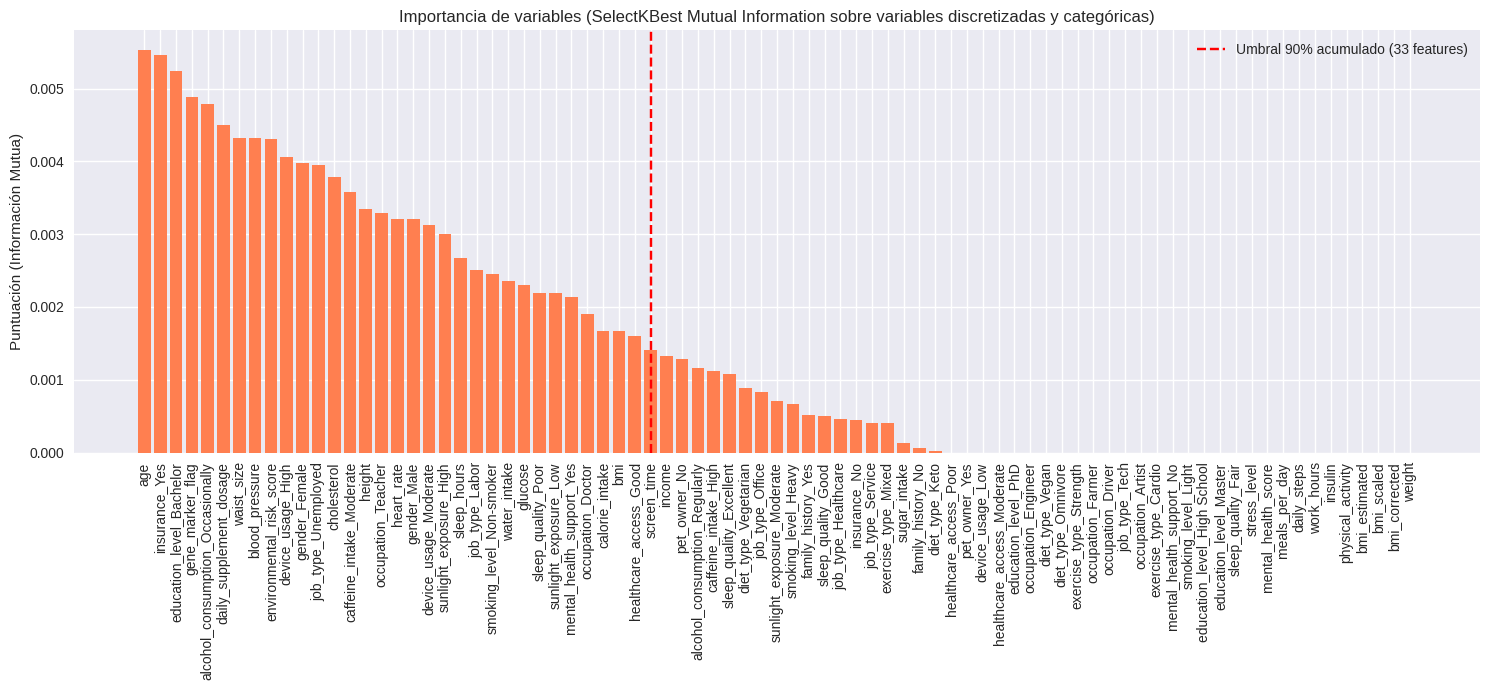

In [102]:
# Separar variables numéricas y categóricas del DataFrame original X
X_num_original = X[numerical_cols]
X_cat_original = X[categorical_cols]

# Imputar valores faltantes en variables numéricas antes de discretizar
imputer_num = SimpleImputer(strategy='mean')
X_num_imputed = imputer_num.fit_transform(X_num_original)
X_num_imputed_df = pd.DataFrame(X_num_imputed, columns=numerical_cols)

# Discretizar variables numéricas en 3 categorías (tercios) - Para consistencia con Chi2
X_num_discretized = X_num_imputed_df.apply(lambda col: pd.qcut(col, q=3, labels=False, duplicates='drop', retbins=False) if col.nunique() > 3 else col)


# Imputar valores faltantes en variables categóricas antes de codificar
imputer_cat = SimpleImputer(strategy='most_frequent')
X_cat_imputed = imputer_cat.fit_transform(X_cat_original)
X_cat_imputed_df = pd.DataFrame(X_cat_imputed, columns=categorical_cols)

# Codificar variables categóricas
encoder_cat = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat_encoded = encoder_cat.fit_transform(X_cat_imputed_df)
cat_feature_names = encoder_cat.get_feature_names_out(categorical_cols)
X_cat_encoded_df = pd.DataFrame(X_cat_encoded, columns=cat_feature_names)


# Combinar variables numéricas discretizadas y categóricas codificadas
# Asegurarse de que los índices coincidan
X_processed_for_mi = pd.concat([X_num_discretized, X_cat_encoded_df], axis=1)

# Verificar si aún hay NaNs después de la combinación (similar a la celda de chi2)
if X_processed_for_mi.isnull().sum().sum() > 0:
    final_imputer = SimpleImputer(strategy='most_frequent') # O 'constant', o considerar qué variables tienen NaNs
    X_processed_for_mi_imputed = final_imputer.fit_transform(X_processed_for_mi)
    X_processed_for_mi = pd.DataFrame(X_processed_for_mi_imputed, columns=X_processed_for_mi.columns)


# Aplicar SelectKBest con mutual_info_classif sobre los datos preparados
# Usamos random_state para reproducibilidad
selector_mi = SelectKBest(score_func=lambda X, y: mutual_info_classif(X, y, random_state=42), k='all')
selector_mi.fit(X_processed_for_mi, y)

scores_mi = selector_mi.scores_
features_mi = X_processed_for_mi.columns # Usar nombres de columnas combinadas

# Ordenar variables por puntuación descendente
indices_mi = np.argsort(scores_mi)[::-1]
sorted_scores_mi = scores_mi[indices_mi]
sorted_features_mi = features_mi[indices_mi]

# Cálculo del porcentaje acumulado de la puntuación
cumulative_mi = np.cumsum(sorted_scores_mi) / np.sum(sorted_scores_mi)

# Seleccionar variables que acumulan hasta 90% del total de puntuación
# Asegurarse de que el índice no exceda el número de características
cutoff_index_mi = np.searchsorted(cumulative_mi, 0.90) + 1
# Ajustar si el índice calculado es mayor que el número total de características
selected_mi_count = min(cutoff_index_mi, len(sorted_features_mi))
selected_features_by_mi = sorted_features_mi[:selected_mi_count]

print(f"Número de características para alcanzar al menos el 90% del puntaje total (Mutual Information): {selected_mi_count}")
print(f"Características seleccionadas ({selected_mi_count}): {list(selected_features_by_mi)}")

# Graficar puntuaciones y el umbral 90%
plt.figure(figsize=(15, 7)) # Aumentar tamaño para mejor visualización con muchas features
plt.bar(range(len(sorted_scores_mi)), sorted_scores_mi, color='coral')
plt.xticks(range(len(sorted_features_mi)), sorted_features_mi, rotation=90)
plt.ylabel("Puntuación (Información Mutua)")
plt.title("Importancia de variables (SelectKBest Mutual Information sobre variables discretizadas y categóricas)")
# El umbral es selected_mi_count - 1 porque los índices son base 0
plt.axvline(selected_mi_count - 1, color='red', linestyle='--', label=f'Umbral 90% acumulado ({selected_mi_count} features)')
plt.legend()
plt.tight_layout() # Ajusta el diseño para evitar solapamiento
plt.show()

### Incrustado (Random Forest)

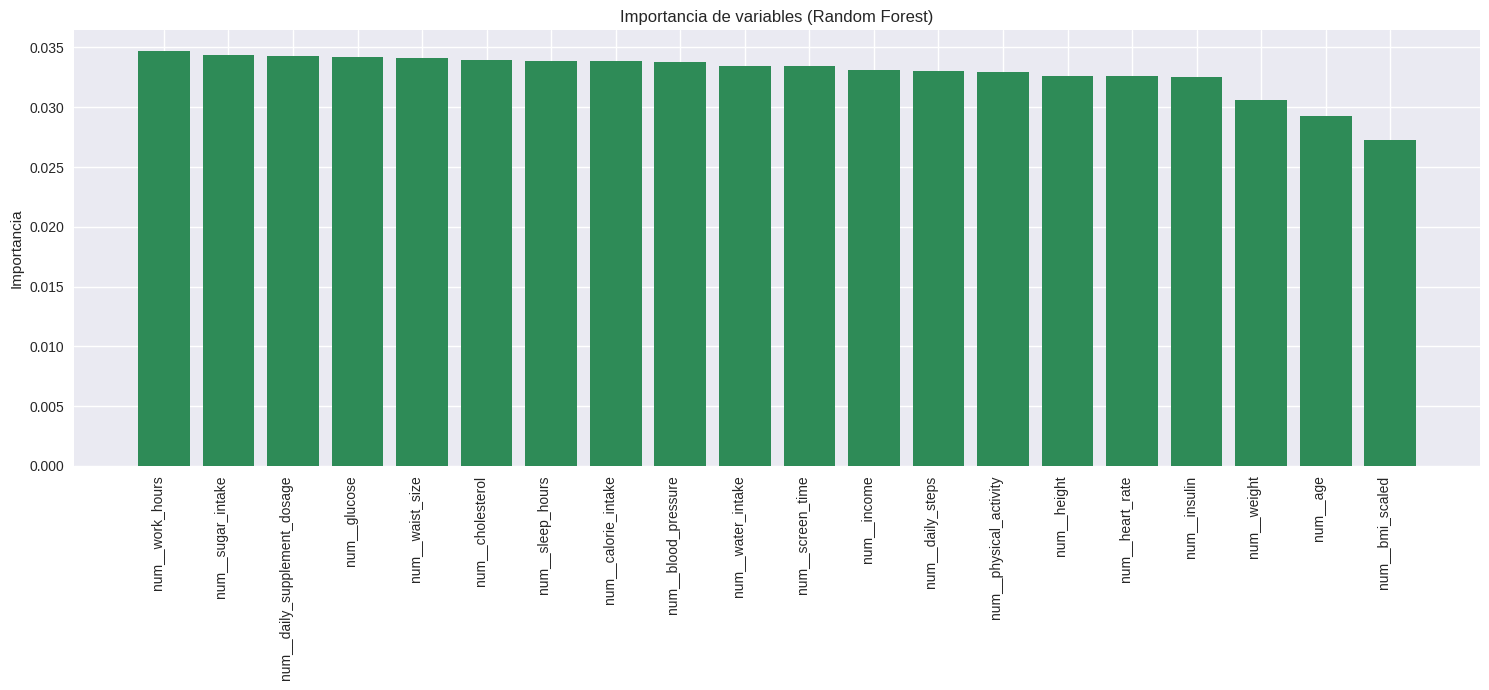

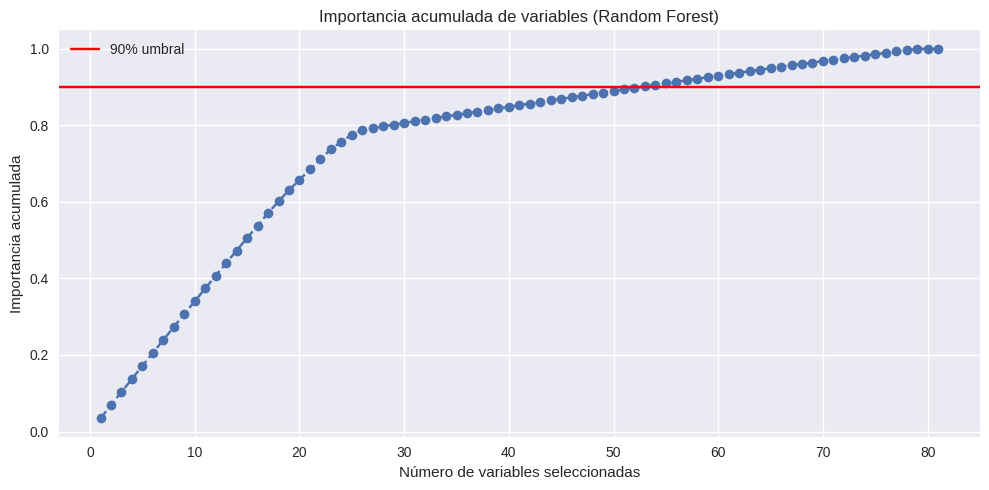

Seleccionando 53 variables para cubrir al menos el 90.0% de la importancia:
['num__work_hours', 'num__sugar_intake', 'num__daily_supplement_dosage', 'num__glucose', 'num__waist_size', 'num__cholesterol', 'num__sleep_hours', 'num__calorie_intake', 'num__blood_pressure', 'num__water_intake', 'num__screen_time', 'num__income', 'num__daily_steps', 'num__physical_activity', 'num__height', 'num__heart_rate', 'num__insulin', 'num__weight', 'num__age', 'num__bmi_scaled', 'num__bmi_estimated', 'num__bmi_corrected', 'num__bmi', 'num__stress_level', 'num__mental_health_score', 'num__meals_per_day', 'cat__exercise_type_Strength', 'cat__sunlight_exposure_Low', 'cat__sunlight_exposure_Moderate', 'cat__family_history_Yes', 'cat__smoking_level_Light', 'cat__diet_type_Vegetarian', 'cat__education_level_Master', 'cat__healthcare_access_Good', 'cat__device_usage_Moderate', 'cat__family_history_No', 'cat__insurance_Yes', 'cat__mental_health_support_No', 'cat__smoking_level_Non-smoker', 'cat__healthcare_ac

In [103]:
# Entrenar modelo Random Forest en los datos preprocesados de entrenamiento
# Usamos un random_state para reproducibilidad
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_processed, y_train)

# Obtener importancias y ordenarlas
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Obtener los nombres de las características preprocesadas
# Asumimos que 'preprocessor' está definido en una celda anterior ejecutada
feature_names = preprocessor.get_feature_names_out()


# Graficar las 20 variables más importantes (o menos si hay menos de 20)
n_features_to_plot = min(20, len(feature_names)) # Graficar hasta 20 o el total si es menor
plt.figure(figsize=(15, 7))
plt.title("Importancia de variables (Random Forest)")
plt.bar(range(n_features_to_plot), importances[indices][:n_features_to_plot], color='seagreen')
plt.xticks(range(n_features_to_plot), feature_names[indices][:n_features_to_plot], rotation=90, ha='right')
plt.ylabel('Importancia')
plt.tight_layout()
plt.show()

# Importancia acumulada
sorted_importances = importances[indices]
cumulative_importance = np.cumsum(sorted_importances)

# Gráfico de importancia acumulada
plt.figure(figsize=(10,5))
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o', linestyle='--')
plt.axhline(y=0.9, color='r', linestyle='-', label='90% umbral')
plt.xlabel('Número de variables seleccionadas')
plt.ylabel('Importancia acumulada')
plt.title('Importancia acumulada de variables (Random Forest)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Seleccionar variables para alcanzar 90% de importancia
cutoff = 0.9
# Encontrar el índice donde la importancia acumulada alcanza o supera el 90%
num_features = np.searchsorted(cumulative_importance, cutoff) + 1
selected_features = feature_names[indices][:num_features]

print(f"Seleccionando {num_features} variables para cubrir al menos el {cutoff*100}% de la importancia:")
print(selected_features.tolist())

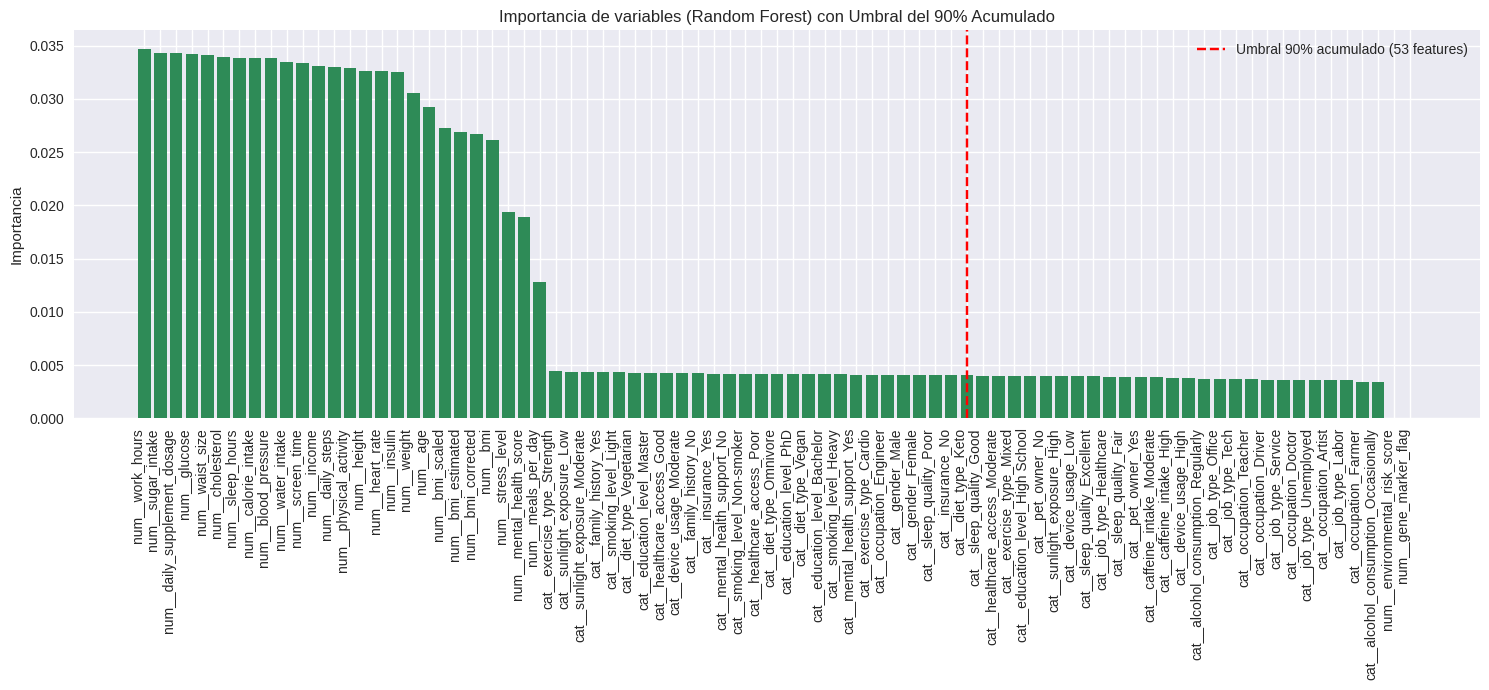

Características seleccionadas (53): ['num__work_hours', 'num__sugar_intake', 'num__daily_supplement_dosage', 'num__glucose', 'num__waist_size', 'num__cholesterol', 'num__sleep_hours', 'num__calorie_intake', 'num__blood_pressure', 'num__water_intake', 'num__screen_time', 'num__income', 'num__daily_steps', 'num__physical_activity', 'num__height', 'num__heart_rate', 'num__insulin', 'num__weight', 'num__age', 'num__bmi_scaled', 'num__bmi_estimated', 'num__bmi_corrected', 'num__bmi', 'num__stress_level', 'num__mental_health_score', 'num__meals_per_day', 'cat__exercise_type_Strength', 'cat__sunlight_exposure_Low', 'cat__sunlight_exposure_Moderate', 'cat__family_history_Yes', 'cat__smoking_level_Light', 'cat__diet_type_Vegetarian', 'cat__education_level_Master', 'cat__healthcare_access_Good', 'cat__device_usage_Moderate', 'cat__family_history_No', 'cat__insurance_Yes', 'cat__mental_health_support_No', 'cat__smoking_level_Non-smoker', 'cat__healthcare_access_Poor', 'cat__diet_type_Omnivore', '

In [104]:
# Asegurarse de que las variables necesarias (sorted_importances, indices, feature_names, cumulative_importance, num_features, selected_features)
# estén disponibles desde la celda donde se entrenó el modelo RF (C_Y-Oe3VZ8J6).

# Graficar la importancia de todas las variables y el umbral del 90%
plt.figure(figsize=(15, 7))
plt.title("Importancia de variables (Random Forest) con Umbral del 90% Acumulado")
# Graficar la importancia de todas las variables
plt.bar(range(len(sorted_importances)), sorted_importances, color='seagreen')
# Usar feature_names[indices] para los nombres de las características ordenadas
plt.xticks(range(len(feature_names)), feature_names[indices], rotation=90, ha='right')
plt.ylabel('Importancia')
# Añadir línea vertical para el umbral del 90%
plt.axvline(x=num_features - 1, color='red', linestyle='--', label=f'Umbral 90% acumulado ({num_features} features)') # num_features-1 porque los índices son base 0
plt.legend()
plt.tight_layout() # Ajusta el diseño para evitar solapamiento
plt.show()

# Opcional: Imprimir las variables seleccionadas nuevamente para confirmación
print(f"Características seleccionadas ({num_features}): {selected_features.tolist()}")

### Selección por envoltura (RFECV con LogisticRegression)

Número óptimo de variables: 1
Variables seleccionadas por RFECV: ['num__bmi_scaled']


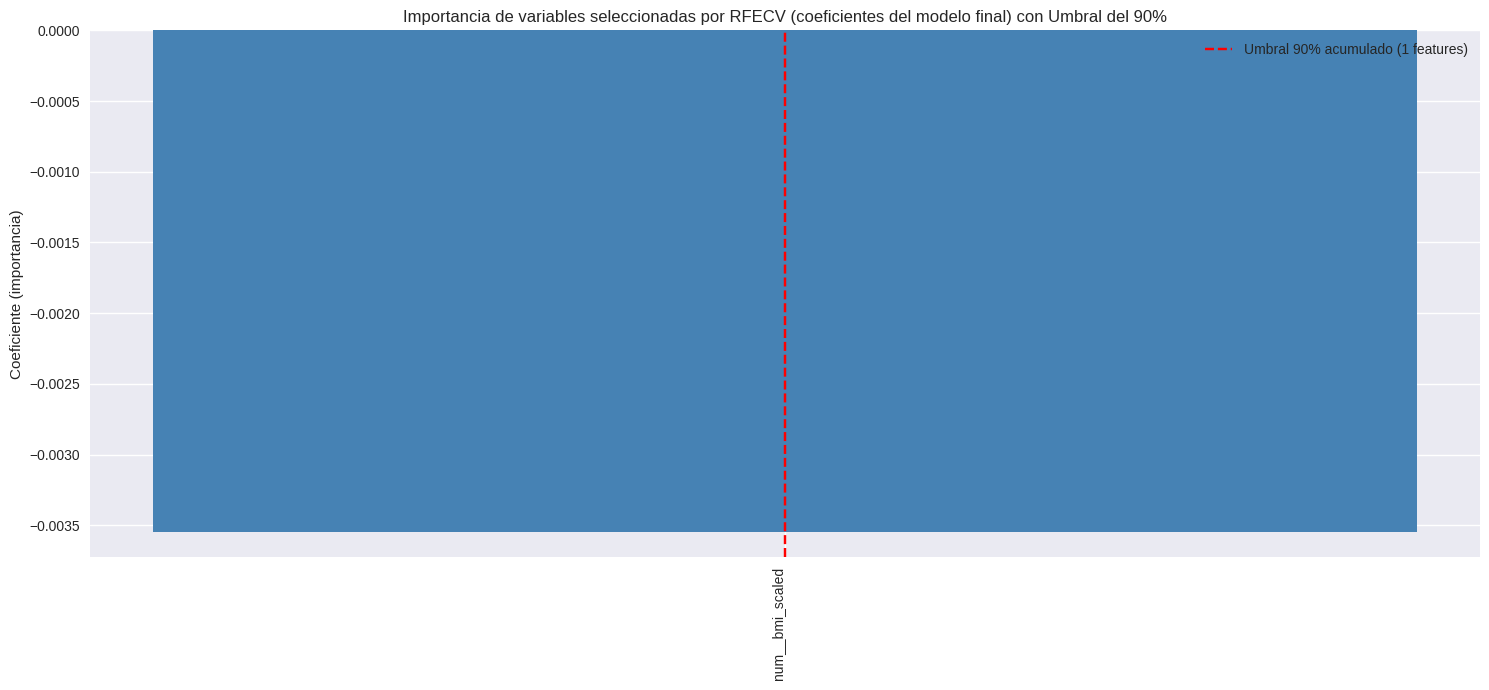

Variables seleccionadas por RFECV que acumulan al menos 90% de importancia (basado en coeficientes, total 1):
['num__bmi_scaled']


In [105]:
# Configuración del modelo base para RFECV
# Usamos max_iter para evitar advertencias de convergencia
model = LogisticRegression(max_iter=1000, random_state=42)

# RFECV para selección automática de variables
# Usaremos StratifiedKFold para mantener la proporción de clases en cada fold
cv = StratifiedKFold(5, shuffle=True, random_state=42)

# Aplicar RFECV directamente sobre los datos preprocesados (escalados y OHE)
# Si X_train_processed no estuviera escalado, necesitaríamos un scaler en el pipeline aquí.
rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='accuracy')

# RFECV es un transformador, lo ajustamos a los datos de entrenamiento
rfecv.fit(X_train_processed, y_train)

print(f"Número óptimo de variables: {rfecv.n_features_}")

# Obtener los nombres de las características originales después del preprocesamiento
feature_names_processed = preprocessor.get_feature_names_out()

# Obtener las variables seleccionadas por RFECV
selected_features_rfecv = feature_names_processed[rfecv.support_]
print("Variables seleccionadas por RFECV:", selected_features_rfecv.tolist())

# Obtener coeficientes del modelo final entrenado con las variables seleccionadas por RFECV
coefs = rfecv.estimator_.coef_.flatten()
features = selected_features_rfecv # Usar solo las variables seleccionadas por RFECV

# Ordenar variables por coeficiente absoluto (importancia)
indices_coefs = np.argsort(np.abs(coefs))[::-1]

# Cálculo del porcentaje acumulado de la importancia de los coeficientes
abs_coefs_sorted = np.abs(coefs)[indices_coefs]
cumulative_importance_coefs = np.cumsum(abs_coefs_sorted) / np.sum(abs_coefs_sorted)

# Seleccionar variables que acumulan al menos 90% de importancia de coeficientes
cutoff_idx_coefs = np.searchsorted(cumulative_importance_coefs, 0.90) + 1
# Ajustar si el índice calculado excede el número de características seleccionadas por RFECV
selected_90_percent_coefs = features[indices_coefs][:min(cutoff_idx_coefs, len(features))]

# Barra de coeficientes ordenados con umbral del 90%
plt.figure(figsize=(15,7)) # Aumentar tamaño para mejor visualización con muchas features
plt.bar(range(len(indices_coefs)), coefs[indices_coefs], color='steelblue')
plt.xticks(range(len(indices_coefs)), features[indices_coefs], rotation=90, ha='right')
plt.ylabel("Coeficiente (importancia)")
plt.title("Importancia de variables seleccionadas por RFECV (coeficientes del modelo final) con Umbral del 90%")
# Añadir línea vertical para el umbral del 90% de importancia acumulada de coeficientes
plt.axvline(x=cutoff_idx_coefs - 1, color='red', linestyle='--', label=f'Umbral 90% acumulado ({cutoff_idx_coefs} features)')
plt.legend()
plt.tight_layout()
plt.show()


print(f"Variables seleccionadas por RFECV que acumulan al menos 90% de importancia (basado en coeficientes, total {len(selected_90_percent_coefs)}):")
print(selected_90_percent_coefs.tolist())

### Comparativa

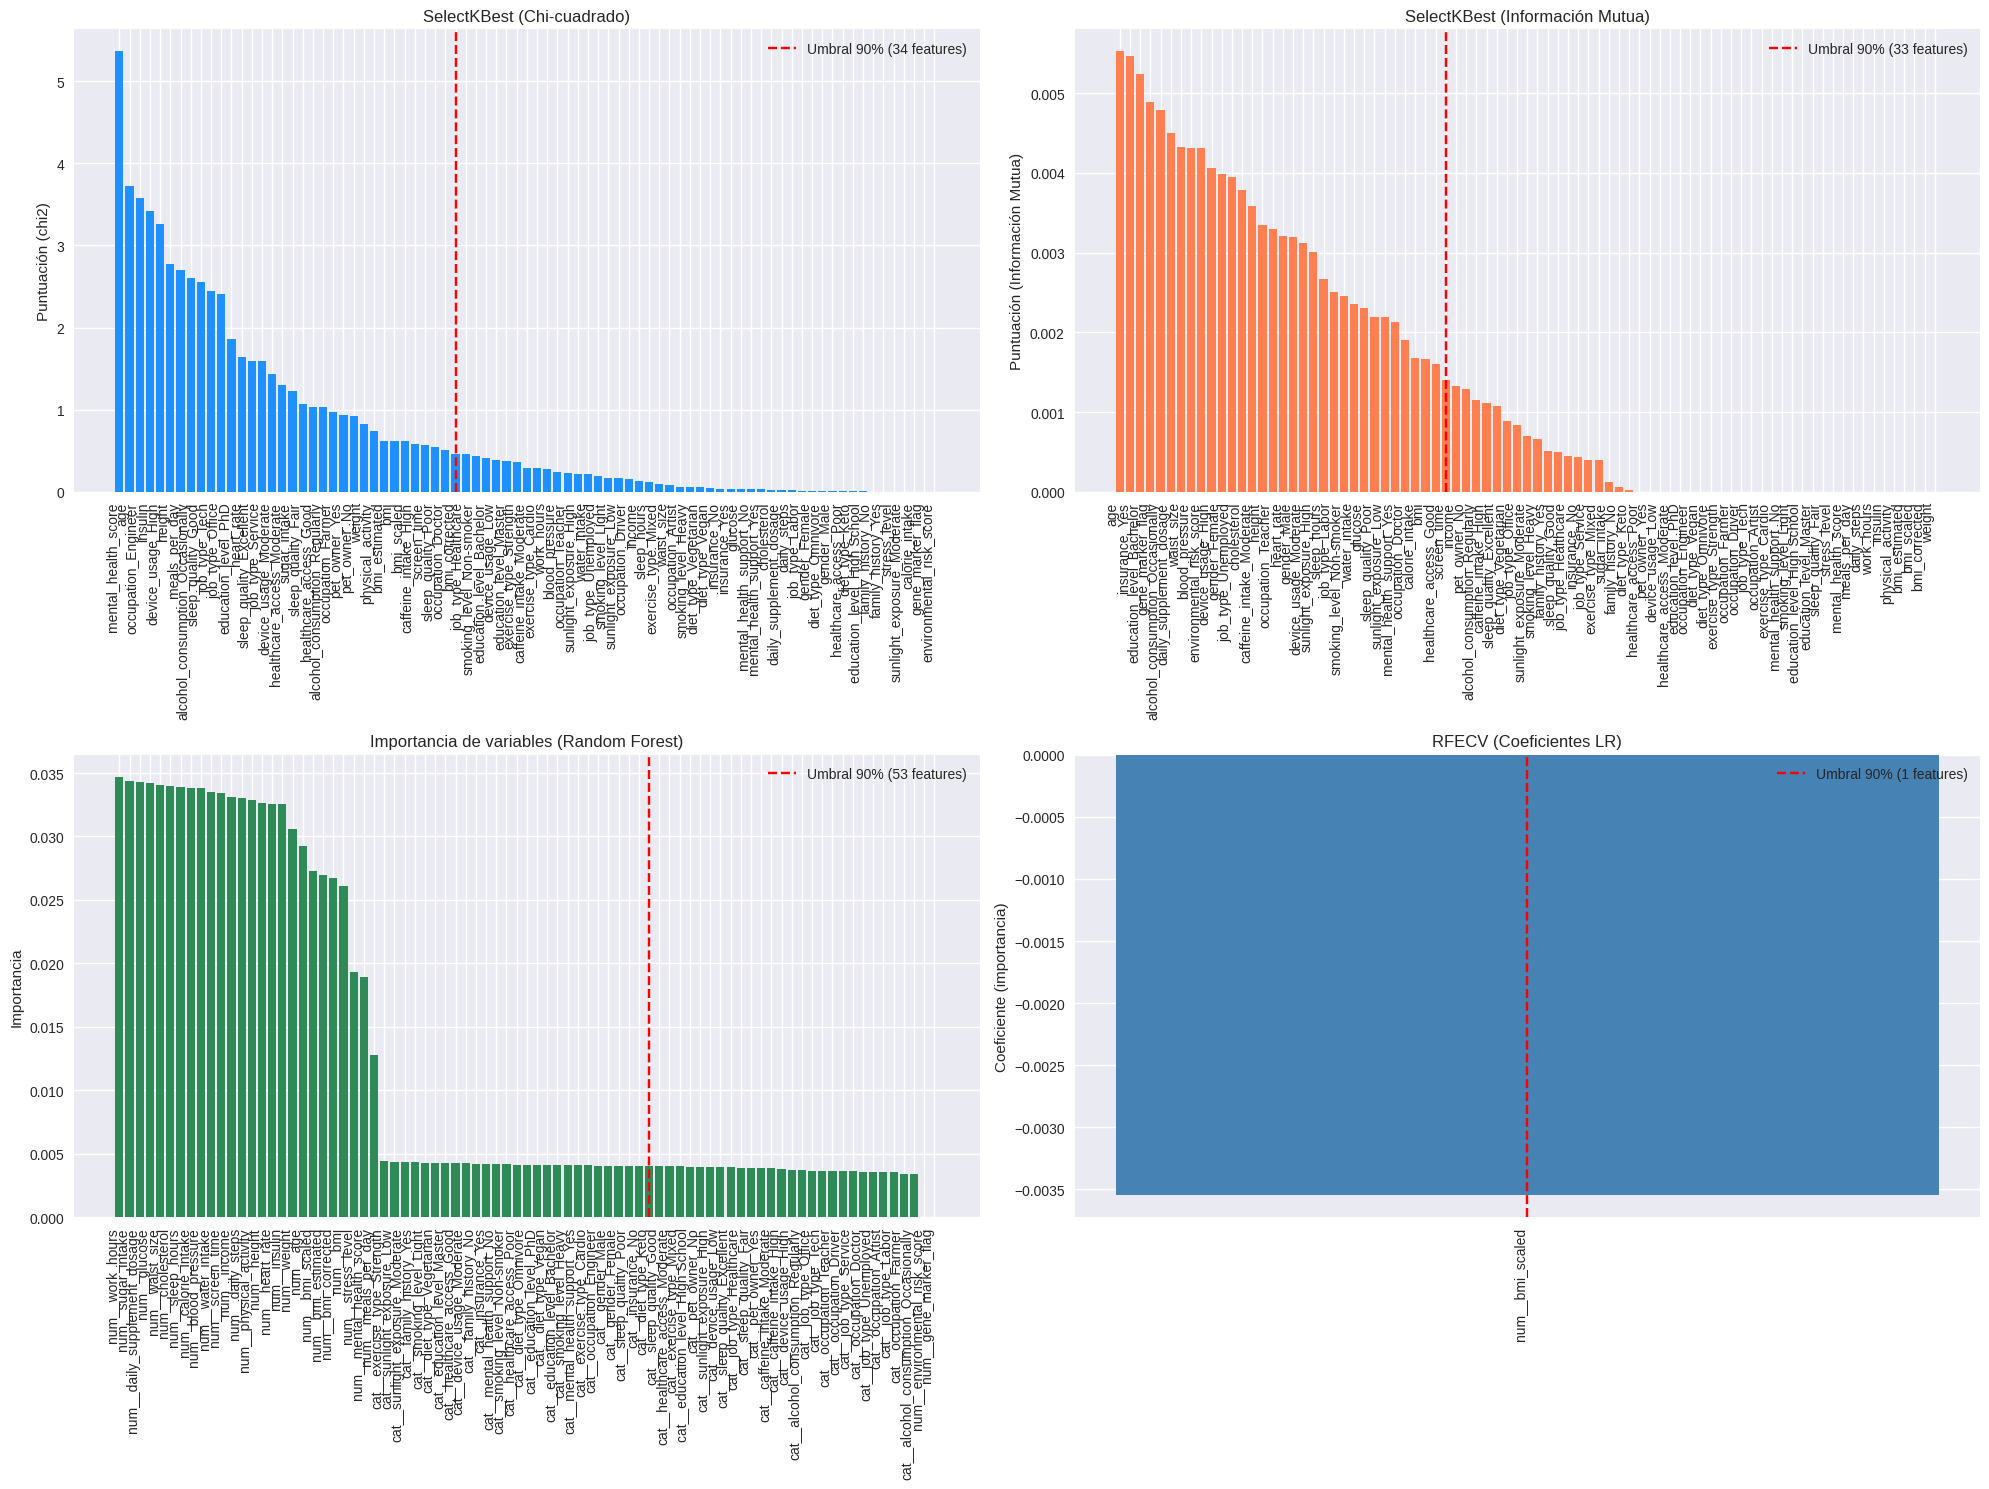

In [106]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten() # Para facilitar el acceso a los subgráficos

# Gráfico 1: SelectKBest (Chi-cuadrado)
axes[0].bar(range(len(sorted_scores_filter)), sorted_scores_filter, color='dodgerblue')
axes[0].set_xticks(range(len(sorted_features_filter)))
axes[0].set_xticklabels(sorted_features_filter, rotation=90, ha='right')
axes[0].set_ylabel("Puntuación (chi2)")
axes[0].set_title("SelectKBest (Chi-cuadrado)")
axes[0].axvline(x=selected_filter_count - 1, color='red', linestyle='--', label=f'Umbral 90% ({selected_filter_count} features)')
axes[0].legend()

# Gráfico 2: SelectKBest (Información Mutua)
axes[1].bar(range(len(sorted_scores_mi)), sorted_scores_mi, color='coral')
axes[1].set_xticks(range(len(sorted_features_mi)))
axes[1].set_xticklabels(sorted_features_mi, rotation=90, ha='right')
axes[1].set_ylabel("Puntuación (Información Mutua)")
axes[1].set_title("SelectKBest (Información Mutua)")
axes[1].axvline(x=selected_mi_count - 1, color='red', linestyle='--', label=f'Umbral 90% ({selected_mi_count} features)')
axes[1].legend()

# Gráfico 3: Importancia de Variables (Random Forest)
# Usamos feature_names[indices] que son los nombres ordenados por importancia de RF
axes[2].bar(range(len(sorted_importances)), sorted_importances, color='seagreen')
axes[2].set_xticks(range(len(feature_names)))
axes[2].set_xticklabels(feature_names[indices], rotation=90, ha='right')
axes[2].set_ylabel('Importancia')
axes[2].set_title('Importancia de variables (Random Forest)')
axes[2].axvline(x=num_features - 1, color='red', linestyle='--', label=f'Umbral 90% ({num_features} features)')
axes[2].legend()


# Gráfico 4: RFECV (Coeficientes de LogisticRegression)
# Usamos features[indices_coefs] que son los nombres de las variables seleccionadas por RFECV, ordenadas por coeficiente
axes[3].bar(range(len(coefs[indices_coefs])), coefs[indices_coefs], color='steelblue')
axes[3].set_xticks(range(len(features[indices_coefs])))
axes[3].set_xticklabels(features[indices_coefs], rotation=90, ha='right')
axes[3].set_ylabel("Coeficiente (importancia)")
axes[3].set_title("RFECV (Coeficientes LR)")
axes[3].axvline(x=cutoff_idx_coefs - 1, color='red', linestyle='--', label=f'Umbral 90% ({cutoff_idx_coefs} features)')
axes[3].legend()


plt.tight_layout()
plt.show()

### Base de Datos Final

Se eligió la importancia de variables de Random Forest como el método de selección de características principal por varias razones, especialmente en comparación con los enfoques SelectKBest (Chi-cuadrado e Información Mutua) y RFECV con Regresión Logística:

*   **Capacidad para capturar interacciones no lineales**: A diferencia de SelectKBest con Chi-cuadrado o Información Mutua, que evalúan la relación de cada característica *individualmente* con la variable objetivo, o RFECV con Regresión Logística que asume una relación lineal, Random Forest es un modelo basado en árboles que puede capturar **interacciones complejas y no lineales** entre las características. Esto es crucial en datasets donde la relación entre las variables de estilo de vida y salud y el riesgo de enfermedad podría no ser simplemente lineal.
*   **Manejo implícito de tipos de datos**: Random Forest puede manejar variables numéricas y categóricas de forma más natural que métodos que requieren discretización específica (como Chi-cuadrado) o codificación detallada antes de la selección. Al entrenar el modelo, la importancia se calcula directamente a partir de la mejora en la pureza de los nodos en los árboles.
*   **Incrustado (Embedded Method)**: La selección se realiza como parte del proceso de entrenamiento del modelo, lo que la hace eficiente una vez que el modelo está entrenado.
*   **Resultados de SelectKBest y RFECV**: Observamos que SelectKBest con Chi-cuadrado e Información Mutua seleccionaron un número similar de características, pero la naturaleza de Chi-cuadrado requirió discretización explícita de variables numéricas, lo cual puede simplificar demasiado algunas relaciones. RFECV con Regresión Logística identificó un número muy pequeño de características óptimas (como se vio en el gráfico de coeficientes y el número óptimo), lo que sugiere que una relación lineal simple podría no ser suficiente para capturar la complejidad del problema. La importancia de Random Forest proporcionó una visión más rica de qué variables contribuyen al modelo.

Por lo tanto, la importancia de variables de Random Forest se considera un buen equilibrio entre la capacidad de modelar relaciones complejas y la eficiencia para este dataset, ofreciendo un conjunto de características que probablemente sean más relevantes para modelos predictivos posteriores que pueden capturar estas no linealidades.

In [107]:
# Obtener los nombres de todas las características procesadas
feature_names_processed = preprocessor.get_feature_names_out()

# Identificar los índices de las características seleccionadas por Random Forest
selected_indices_rf = [i for i, feature in enumerate(feature_names_processed) if feature in selected_features]

# Crear los nuevos conjuntos de datos con las características seleccionadas
X_train_selected_rf = X_train_processed[:, selected_indices_rf]
X_test_selected_rf = X_test_processed[:, selected_indices_rf]

print(f"Shape de X_train_selected_rf: {X_train_selected_rf.shape}")
print(f"Shape de X_test_selected_rf: {X_test_selected_rf.shape}")

# Opcional: Mostrar los nombres de las características seleccionadas
print("\nCaracterísticas seleccionadas por Random Forest:")
print(selected_features.tolist())

Shape de X_train_selected_rf: (14000, 53)
Shape de X_test_selected_rf: (6000, 53)

Características seleccionadas por Random Forest:
['num__work_hours', 'num__sugar_intake', 'num__daily_supplement_dosage', 'num__glucose', 'num__waist_size', 'num__cholesterol', 'num__sleep_hours', 'num__calorie_intake', 'num__blood_pressure', 'num__water_intake', 'num__screen_time', 'num__income', 'num__daily_steps', 'num__physical_activity', 'num__height', 'num__heart_rate', 'num__insulin', 'num__weight', 'num__age', 'num__bmi_scaled', 'num__bmi_estimated', 'num__bmi_corrected', 'num__bmi', 'num__stress_level', 'num__mental_health_score', 'num__meals_per_day', 'cat__exercise_type_Strength', 'cat__sunlight_exposure_Low', 'cat__sunlight_exposure_Moderate', 'cat__family_history_Yes', 'cat__smoking_level_Light', 'cat__diet_type_Vegetarian', 'cat__education_level_Master', 'cat__healthcare_access_Good', 'cat__device_usage_Moderate', 'cat__family_history_No', 'cat__insurance_Yes', 'cat__mental_health_support_N

## 5. PCA

Aplicamos Análisis de Componentes Principales (PCA) a las variables numéricas para reducir la dimensionalidad manteniendo el 70% de la varianza explicada.

Componentes PCA (entrenamiento): 22
Componentes PCA (prueba): 22


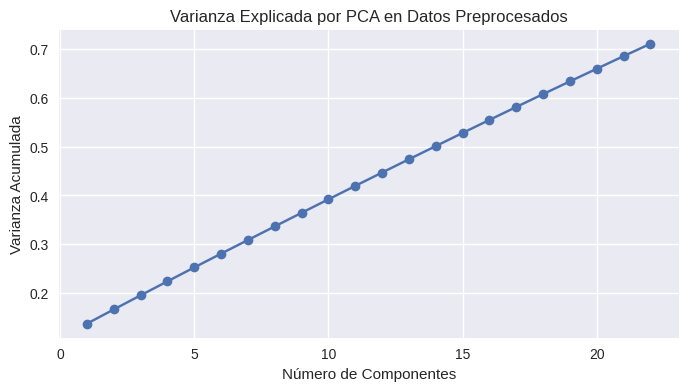

In [108]:
# PCA sobre X_train_processed
# X_train_processed ya contiene las variables numéricas escaladas y categóricas codificadas.
# Aplicar PCA a este conjunto transformará el espacio de características completo.

pca = PCA(n_components=0.7, random_state=123)
X_train_pca = pca.fit_transform(X_train_processed)

# Para el conjunto de prueba, solo transformamos usando el PCA ajustado en el entrenamiento
X_test_pca = pca.transform(X_test_processed)

print(f"Componentes PCA (entrenamiento): {X_train_pca.shape[1]}")
print(f"Componentes PCA (prueba): {X_test_pca.shape[1]}")


plt.figure(figsize=(8,4))
# El rango de componentes es hasta el número total de características en X_train_processed
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.title('Varianza Explicada por PCA en Datos Preprocesados')
plt.grid(True)
plt.show()

Componentes PCA (entrenamiento): 14
Componentes PCA (prueba): 14


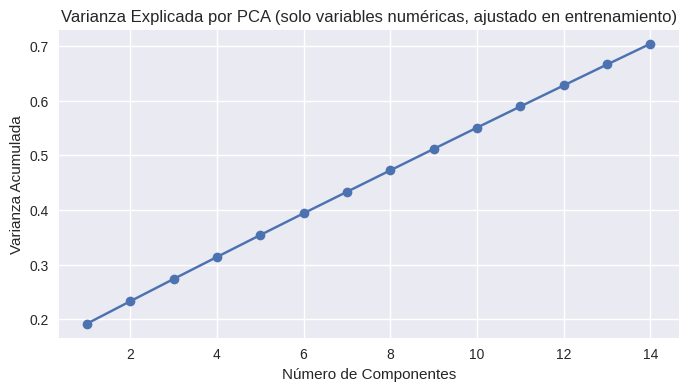

In [109]:
# PCA sobre variables numéricas
# Usaremos los conjuntos de entrenamiento y prueba ya divididos (X_train, X_test)

# Imputar y escalar las variables numéricas usando un pipeline ajustado SOLO en entrenamiento
num_pipeline_pca = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Ajustar el pipeline de preprocesamiento numérico en los datos de entrenamiento
X_train_num_processed = num_pipeline_pca.fit_transform(X_train[numerical_cols])

# Aplicar el pipeline de preprocesamiento numérico a los datos de prueba (solo transform)
X_test_num_processed = num_pipeline_pca.transform(X_test[numerical_cols])

# Aplicar PCA SOLO a los datos numéricos de entrenamiento procesados
pca = PCA(n_components=0.7, random_state=123)
X_train_pca_numerical = pca.fit_transform(X_train_num_processed)

# Aplicar la transformación PCA aprendida a los datos numéricos de prueba procesados
X_test_pca_numerical = pca.transform(X_test_num_processed)

print(f"Componentes PCA (entrenamiento): {X_train_pca_numerical.shape[1]}")
print(f"Componentes PCA (prueba): {X_test_pca_numerical.shape[1]}")


plt.figure(figsize=(8,4))
# El rango de componentes es hasta el número total de componentes encontrados por PCA
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.title('Varianza Explicada por PCA (solo variables numéricas, ajustado en entrenamiento)')
plt.grid(True)
plt.show()

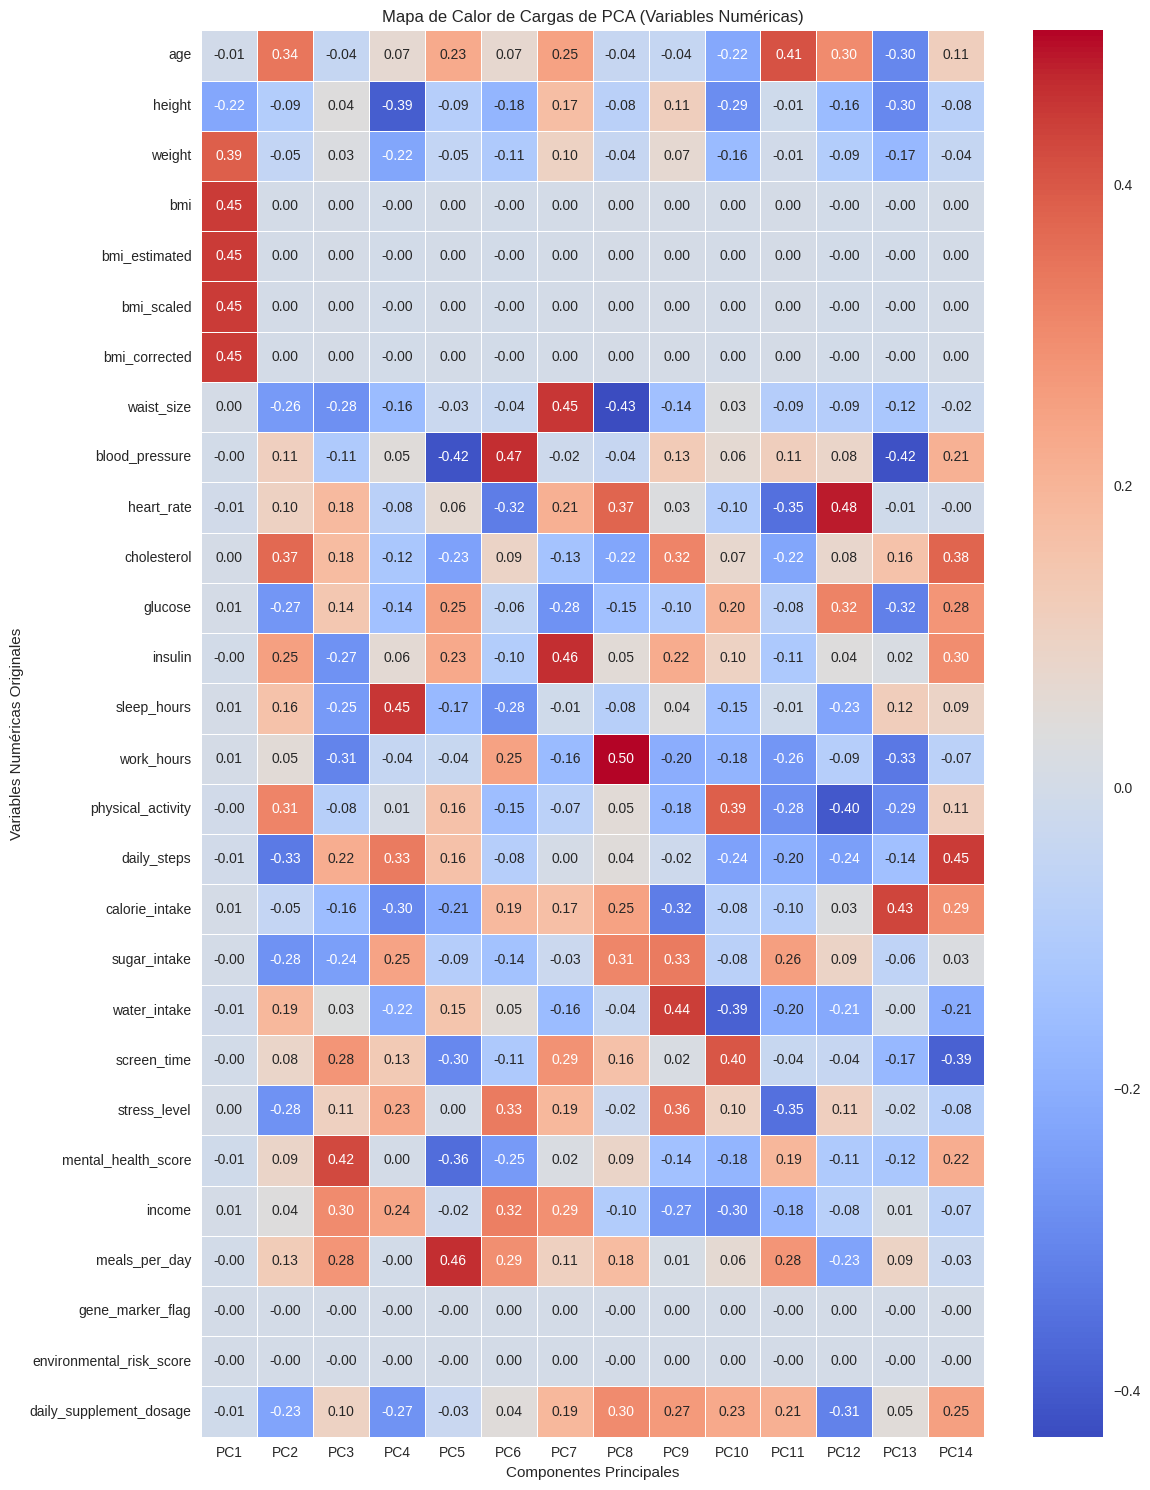

In [110]:
# Obtener los loadings (componentes) del objeto PCA
# Los loadings son los vectores propios, que están almacenados en pca.components_
loadings = pca.components_.T # Transponemos para tener las características como filas y componentes como columnas inicialmente

# Crear un DataFrame para los loadings para facilitar la visualización con nombres
# Las filas son las características originales, las columnas son los componentes principales
loadings_df = pd.DataFrame(loadings, index=numerical_cols,
                           columns=[f'PC{i+1}' for i in range(loadings.shape[1])])

# Graficar el mapa de calor de los loadings
plt.figure(figsize=(12, 15)) # Ajusta el tamaño para visualizar todas las características
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Calor de Cargas de PCA (Variables Numéricas)')
plt.xlabel('Componentes Principales')
plt.ylabel('Variables Numéricas Originales')
plt.yticks(rotation=0) # Asegura que los nombres de las características estén horizontales
plt.tight_layout() # Ajusta el diseño para evitar solapamiento
plt.show()

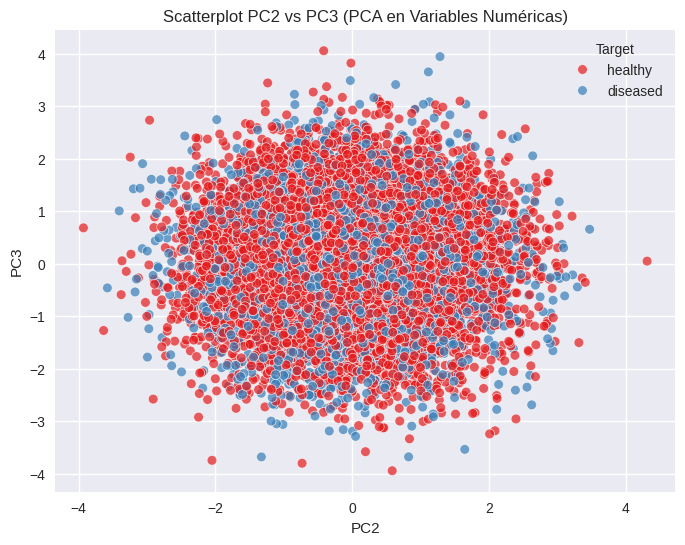

In [111]:
# Scatterplot PC2 vs PC3
plt.figure(figsize=(8,6))
# Usamos la segunda y tercera componente de X_train_pca_numerical (índices 1 y 2)
sns.scatterplot(x=X_train_pca_numerical[:,1], y=X_train_pca_numerical[:,2], hue=y_train, palette='Set1', alpha=0.7)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('Scatterplot PC2 vs PC3 (PCA en Variables Numéricas)')
# La leyenda se generará automáticamente con los valores únicos de y_train ('healthy', 'diseased')
plt.legend(title='Target')
plt.grid(True)
plt.show()

## 6. MCA

Aplicamos Análisis de Correspondencias Múltiples (MCA) a las variables categóricas para reducir la dimensionalidad y capturar patrones en los datos categóricos.

In [112]:
# Pipeline para imputación y OneHotEncoding de categóricas
cat_pipeline_mca = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Aplicar preprocesamiento categórico en train y test
X_train_cat_processed = cat_pipeline_mca.fit_transform(X_train[categorical_cols])
X_test_cat_processed = cat_pipeline_mca.transform(X_test[categorical_cols])

# Convertir a DataFrame para que mca.MCA funcione (necesita nombres de columnas)
cat_feature_names_processed = cat_pipeline_mca.named_steps['encoder'].get_feature_names_out(categorical_cols)
X_train_cat_processed_df = pd.DataFrame(X_train_cat_processed, columns=cat_feature_names_processed, index=X_train.index)
X_test_cat_processed_df = pd.DataFrame(X_test_cat_processed, columns=cat_feature_names_processed, index=X_test.index)

# Aplicar MCA SOLO a los datos categóricos de entrenamiento procesados (OneHotEncoded)
mca_model = mca.MCA(X_train_cat_processed_df, ncols=X_train_cat_processed_df.shape[1])

In [113]:
# Obtener los componentes MCA para entrenamiento y prueba
# fs_r_sup calcula los factores principales para las filas (observaciones)
X_train_mca_categorical = mca_model.fs_r_sup(X_train_cat_processed_df)
X_test_mca_categorical = mca_model.fs_r_sup(X_test_cat_processed_df)

print(f"Shape de X_train_mca_categorical: {X_train_mca_categorical.shape}")
print(f"Shape de X_test_mca_categorical: {X_test_mca_categorical.shape}")

Shape de X_train_mca_categorical: (14000, 36)
Shape de X_test_mca_categorical: (6000, 36)


In [114]:
# Valores singulares y autovalores
sv = mca_model.s
eigvals = sv ** 2
explained_var = eigvals / eigvals.sum()
cum_explained_var = np.cumsum(explained_var)

# Número de componentes para >=70% varianza explicada
# np.argmax devuelve el índice del primer True
# Añadimos 1 porque los índices son base 0
n_components_70 = np.argmax(cum_explained_var >= 0.7) + 1
print(f"Componentes MCA para >=70% varianza explicada: {n_components_70}")

Componentes MCA para >=70% varianza explicada: 25


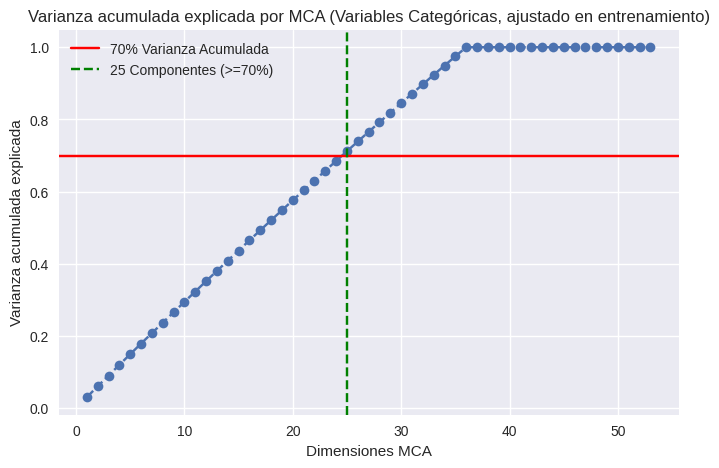

In [115]:
# Asegurarse de que cum_explained_var y n_components_70 están disponibles
# cum_explained_var y n_components_70 se definieron en la celda r0B5rdVtoFOb

# Graficar varianza acumulada
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cum_explained_var)+1), cum_explained_var, marker='o', linestyle='--')
plt.axhline(y=0.7, color='r', linestyle='-', label='70% Varianza Acumulada')
# Añadir línea vertical en n_components_70
plt.axvline(x=n_components_70, color='g', linestyle='--', label=f'{n_components_70} Componentes (>=70%)')
plt.xlabel('Dimensiones MCA')
plt.ylabel('Varianza acumulada explicada')
plt.title('Varianza acumulada explicada por MCA (Variables Categóricas, ajustado en entrenamiento)')
plt.grid(True)
plt.legend()
plt.show()

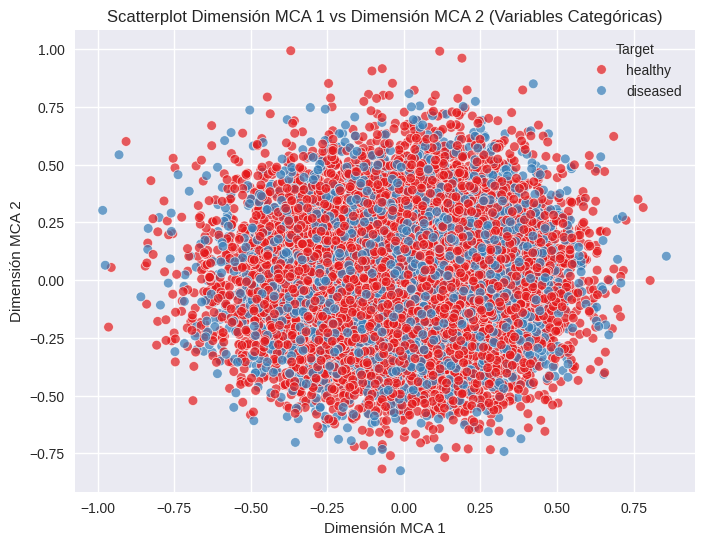

In [116]:
plt.figure(figsize=(8,6))
# Usamos los dos primeros componentes de X_train_mca_categorical (índices 0 y 1)
sns.scatterplot(x=X_train_mca_categorical[:,0], y=X_train_mca_categorical[:,1], hue=y_train, palette='Set1', alpha=0.7)
plt.xlabel('Dimensión MCA 1')
plt.ylabel('Dimensión MCA 2')
plt.title('Scatterplot Dimensión MCA 1 vs Dimensión MCA 2 (Variables Categóricas)')
# La leyenda se generará automáticamente con los valores únicos de y_train ('healthy', 'diseased')
plt.legend(title='Target')
plt.grid(True)
plt.show()

## 7. Concatenar PCA y MCA

In [117]:
# Seleccionar solo los primeros n_components_70 de MCA
X_train_mca_selected = X_train_mca_categorical[:, :n_components_70]
X_test_mca_selected = X_test_mca_categorical[:, :n_components_70]


# Concatenar los componentes de PCA y los componentes seleccionados de MCA
X_train_pca_mca = np.hstack((X_train_pca_numerical, X_train_mca_selected))
X_test_pca_mca = np.hstack((X_test_pca_numerical, X_test_mca_selected))

print(f"Shape de X_train_pca_mca: {X_train_pca_mca.shape}")
print(f"Shape de X_test_pca_mca: {X_test_pca_mca.shape}")

Shape de X_train_pca_mca: (14000, 39)
Shape de X_test_pca_mca: (6000, 39)
